In [1]:
%matplotlib inline

use_constraints = False

import pynamics
from pynamics.frame import Frame
from pynamics.variable_types import Differentiable,Constant
from pynamics.system import System
from pynamics.body import Body
from pynamics.dyadic import Dyadic
from pynamics.output import Output,PointsOutput
from pynamics.particle import Particle
from pynamics.constraint import AccelerationConstraint
import pynamics.integration
import numpy
import sympy
import matplotlib.pyplot as plt
plt.ion()
from math import pi

system = System()
pynamics.set_system(__name__,system)

In [2]:
S_shaped=1

lA = Constant(1.5,'lA',system)
lB = Constant(1,'lB',system)
lC = Constant(1.5,'lC',system)

mA = Constant(1.5,'mA',system)
mB = Constant(1,'mB',system)
mC = Constant(1.5,'mC',system)

g = Constant(9.81e-2,'g',system)
b = Constant(1e1,'b',system)
k = Constant(1e1,'k',system)

preload1 = Constant(0*pi/180,'preload1',system)
preload2 = Constant(0*pi/180,'preload2',system)
preload3 = Constant(0*pi/180,'preload3',system)

Ixx_A = Constant(1,'Ixx_A',system)
Iyy_A = Constant(1,'Iyy_A',system)
Izz_A = Constant(1,'Izz_A',system)
Ixx_B = Constant(1,'Ixx_B',system)
Iyy_B = Constant(1,'Iyy_B',system)
Izz_B = Constant(1,'Izz_B',system)
Ixx_C = Constant(1,'Ixx_C',system)
Iyy_C = Constant(1,'Iyy_C',system)
Izz_C = Constant(1,'Izz_C',system)

torque = Constant(3e1,'torque',system)
freq = Constant(5e-1,'freq',system)

In [3]:
x1,x1_d,x1_dd = Differentiable('x1',system)
y1,y1_d,y1_dd = Differentiable('y1',system)
qA,qA_d,qA_dd = Differentiable('qA',system)
qB,qB_d,qB_dd = Differentiable('qB',system)
qC,qC_d,qC_dd = Differentiable('qC',system)

initialvalues = {}
initialvalues[x1]=0
initialvalues[x1_d]=0
initialvalues[y1]=0
initialvalues[y1_d]=0
initialvalues[qA]=0*pi/180
initialvalues[qA_d]=0*pi/180
initialvalues[qB]=0*pi/180
initialvalues[qB_d]=0*pi/180
initialvalues[qC]=S_shaped*0*pi/180
initialvalues[qC_d]=0*pi/180

statevariables = system.get_state_variables()
ini = [initialvalues[item] for item in statevariables]

In [4]:
N = Frame('N',system)
A = Frame('A',system)
B = Frame('B',system)
C = Frame('C',system)

system.set_newtonian(N)

A.rotate_fixed_axis(N,[0,0,1],qA,system)
B.rotate_fixed_axis(A,[0,0,1],qB,system)
C.rotate_fixed_axis(B,[0,0,1],qC,system)

In [5]:
pNA=0*N.x
pA= x1*N.x + y1*N.y
pB = pA + lA*A.y 
pC = pB + lB*B.y 
pD = pC + lC*C.y

pAcm=pA+lA/2*A.y
pBcm=pB+lB/2*B.y
pCcm=pC+lC/2*C.y

In [6]:
wNA = N.get_w_to(A)
wAB = A.get_w_to(B)
wBC = B.get_w_to(C)

vD = pD.time_derivative(N,system)

IA = Dyadic.build(A,Ixx_A,Iyy_A,Izz_A)
IB = Dyadic.build(B,Ixx_B,Iyy_B,Izz_B)
IC = Dyadic.build(C,Ixx_C,Iyy_C,Izz_C)

BodyA = Body('BodyA',A,pAcm,mA,IA,system)
BodyB = Body('BodyB',B,pBcm,mB,IB,system)
BodyC = Body('BodyC',C,pCcm,mC,IC,system)

In [7]:
system.addforce(torque*sympy.sin(freq*2*sympy.pi*system.t)*A.z,wNA)
system.addforce(S_shaped*-torque*sympy.sin(freq*2*sympy.pi*system.t)*C.z,wBC) 


system.addforce(-b*wNA,wNA)
#system.addforce(-b*wAB,wAB)
system.addforce(-b*wBC,wBC)



system.add_spring_force1(k,(qA-preload1)*N.z,wNA) 
#system.add_spring_force1(k,(qB-preload2)*A.z,wAB)
system.add_spring_force1(k,(qC-preload3)*B.z,wBC)





(<pynamics.force.Force at 0x1de62215040>,
 <pynamics.spring.Spring at 0x1de6220f670>)

In [8]:
if use_constraints:
    eq = []
    eq.append(pD)
    eq_d=[item.time_derivative() for item in eq]
    eq_dd=[item.time_derivative() for item in eq_d]
    eq_dd_scalar = []
    eq_dd_scalar.append(eq_dd[0].dot(N.x))
    constraint = AccelerationConstraint(eq_dd_scalar)
    system.add_constraint(constraint)

In [9]:
f,ma = system.getdynamics()

func1,lambda1 = system.state_space_post_invert(f,ma,return_lambda = True)

tol = 1e-7
tinitial = 0
tfinal = 10
fps = 30
tstep = 1/fps
t = numpy.r_[tinitial:tfinal:tstep]

states=pynamics.integration.integrate(func1,ini,t,rtol=tol,atol=tol, args=({'constants':system.constant_values},))

2022-04-12 15:00:52,594 - pynamics.system - INFO - getting dynamic equations
2022-04-12 15:00:54,344 - pynamics.system - INFO - solving a = f/m and creating function
2022-04-12 15:00:55,458 - pynamics.system - INFO - substituting constrained in Ma-f.
2022-04-12 15:00:56,120 - pynamics.system - INFO - done solving a = f/m and creating function
2022-04-12 15:00:56,121 - pynamics.system - INFO - calculating function for lambdas
2022-04-12 15:00:56,593 - pynamics.integration - INFO - beginning integration
2022-04-12 15:00:56,595 - pynamics.system - INFO - integration at time 0000.00
2022-04-12 15:00:58,462 - pynamics.system - INFO - integration at time 0008.50
2022-04-12 15:00:59,163 - pynamics.integration - INFO - finished integration


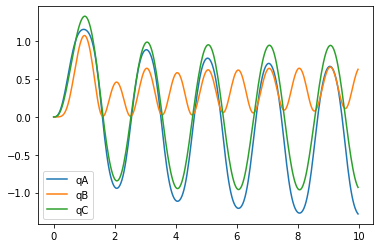

In [10]:
plt.figure()
artists = plt.plot(t,states[:,:3])
plt.legend(artists,['qA','qB','qC'])

2022-04-12 15:01:00,482 - pynamics.output - INFO - calculating outputs
2022-04-12 15:01:00,571 - pynamics.output - INFO - done calculating outputs


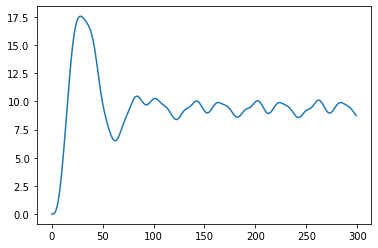

In [11]:
KE = system.get_KE()
PE = system.getPEGravity(pNA) - system.getPESprings()
energy_output = Output([KE-PE],system)
energy_output.calc(states,t)
energy_output.plot_time()

In [12]:
if use_constraints:
    lambda2 = numpy.array([lambda1(item1,item2,system.constant_values) for item1,item2 in zip(t,states)])
    plt.figure()
    plt.plot(t, lambda2)

2022-04-12 15:01:01,150 - pynamics.output - INFO - calculating outputs
2022-04-12 15:01:01,207 - pynamics.output - INFO - done calculating outputs


<AxesSubplot:>

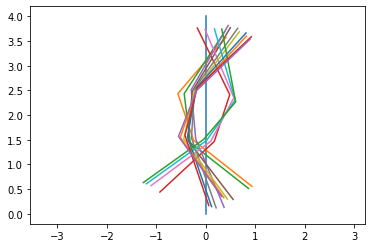

In [13]:
points = [pA,pB,pC,pD]
points_output = PointsOutput(points,system)
y = points_output.calc(states,t)
points_output.plot_time(20)

In [ ]:
points_output.animate(fps = fps,movie_name = 'Ssssssspine2.mp4',lw=2,marker='o',color=(1,0,0,1),linestyle='-')

from matplotlib import animation, rc
from IPython.display import HTML
HTML(points_output.anim.to_html5_video())